
### Distilling extracted dependency patterns for relation extraction
This notebook explores the data here: 

https://zenodo.org/record/3346007#.XYJd7ZNKi-Z
https://www.ncbi.nlm.nih.gov/pubmed/29490008

This repository contains labeled, weighted networks of chemical-gene, gene-gene, gene-disease, and chemical-disease relationships based on single sentences in PubMed abstracts. All raw dependency paths are provided in addition to the labeled relationships.

PART I: Connects dependency paths to labels, or "themes". Each record contains a dependency path followed by its score for each theme, and indicators of whether or not the path is part of the flagship path set for each theme (meaning that it was manually reviewed and determined to reflect that theme). The themes themselves are listed below and are in our paper (reference below).

PART II: Connects sentences to dependency paths. It consists of sentences and associated metadata, entity pairs found in the sentences, and dependency paths connecting those entity pairs. Each record contains the following information:

* PubMed ID
* Sentence number (0 = title)
* First entity name, formatted
* First entity name, location (characters from start of abstract)
* Second entity name, formatted
* Second entity name, location
* First entity name, raw string
* Second entity name, raw string
* First entity name, database ID(s)
* Second entity name, database ID(s)
* First entity type (Chemical, Gene, Disease)
* Second entity type (Chemical, Gene, Disease)
* Dependency path
* Sentence, tokenized

The "with-themes.txt" files only contain dependency paths with corresponding theme assignments from Part I. The plain ".txt" files contain all dependency paths.

In [1]:
import spacy
import random
import matplotlib.pyplot as plt
import numpy
from collections import Counter

from scispacy.hack import visualise_doc, visualise_subtrees

nlp = spacy.load("en_core_sci_md")

def get_distributions_and_data():
    
    f = open("part-i-chemical-gene-path-theme-distributions.txt")

    headers = next(f).strip().split("\t")[1:]

    distributions = {}
    for line in f:
        line = line.strip().split("\t")
    
        distributions[line[0]] = {name: float(value) for name, value in zip(headers, line[1:])}
    
    data = open("part-ii-dependency-paths-chemical-gene-sorted-with-themes.txt")
    data_headers = ["pmid", "sent", "ent1", "ent1_offset", "ent2", "ent2_offset",
                    "ent1_raw", "ent2_raw", "ent1_canonical", "ent2_canonical", 
                    "ent1_type", "ent2_type", "dep", "sent"]

    lines = [{k:v for k,v in zip(data_headers, line.strip().split("\t"))} for line in data]
    
    return lines, distributions
    
data, distributions = get_distributions_and_data()

for d in random.sample(data, 4):
    print()
    print(d["dep"])
    print("Entity 1: ", d["ent1"] )
    print("Entity 2: ", d["ent2"] )
    print(d["sent"])


START_ENTITY|nmod|model model|nmod|END_ENTITY
Entity 1:  CDHP
Entity 2:  S-1
We also performed in vitro experiments using concomitant 5-fluorouracil -LRB- 5-FU -RRB- and CDHP as a drug model of S-1 to determine the effect of S-1 on OSCC invasion and metastasis .

biosynthesis|amod|START_ENTITY enzyme|nmod|biosynthesis END_ENTITY|appos|enzyme
Entity 1:  polyamine
Entity 2:  ornithine_decarboxylase
Induction of ornithine_decarboxylase -LRB- ODC -RRB- , a key enzyme in polyamine biosynthesis , in ODC transgenic skin stimulates epidermal proliferation but not hyperplasia , activates underlying stromal cells and promotes skin_tumorigenesis following a single subthreshold dose of a carcinogen .

homeostasis|compound|START_ENTITY manipulation|nmod|homeostasis target|nmod|manipulation END_ENTITY|nmod|target
Entity 1:  glucose
Entity 2:  AS160
This suggests AS160 as a target for differential manipulation of glucose homeostasis .

activity|nmod|START_ENTITY activity|nummod|END_ENTITY
Entity 1: 

### First look at some patterns in the data:

In [2]:
counter = Counter()
path_lengths = Counter()

for dep, values in distributions.items():
    counter[dep] = sum(list(values.values()))
    length = len(dep.split(" "))
    path_lengths[length] += 1

counter_data = Counter()

for d in data:
    counter_data[d["dep"].lower()] += 1

#### Most common patterns from the distribution file:

In [3]:
for k,v in counter.most_common(20):
    print(k, "\t\t\t\t", v)

start_entity|appos|inhibitor inhibitor|compound|end_entity 				 61702.0
synthase|compound|start_entity synthase|appos|end_entity 				 57993.0
inhibitor|appos|start_entity inhibitor|compound|end_entity 				 39135.0
start_entity|appos|inhibitor inhibitor|nmod|end_entity 				 34476.0
start_entity|appos|inhibitor inhibitor|amod|end_entity 				 32538.0
synthase|amod|start_entity synthase|appos|end_entity 				 32269.0
response|nmod|start_entity response|compound|end_entity 				 30035.0
receptor|amod|start_entity receptor|appos|end_entity 				 26321.0
inhibitor|appos|start_entity inhibitor|amod|end_entity 				 22824.0
transporter|compound|start_entity transporter|appos|end_entity 				 19879.0
receptor|compound|start_entity receptor|appos|end_entity 				 19085.0
inhibitors|amod|start_entity inhibitors|amod|end_entity 				 14603.0
gene|amod|start_entity gene|appos|end_entity 				 11449.0
inhibitor|nsubj|start_entity inhibitor|compound|end_entity 				 11267.0
inhibitor|nsubj|start_entity inhibit

#### Most common patterns from the data file:

In [4]:
for k,v in counter_data.most_common(20):
    print(k, "\t\t\t\t", v)

start_entity|appos|inhibitor inhibitor|compound|end_entity 				 7310
start_entity|appos|inhibitor inhibitor|nmod|end_entity 				 5756
inhibitor|appos|start_entity inhibitor|compound|end_entity 				 4998
phosphorylation|amod|start_entity phosphorylation|nmod|end_entity 				 4909
start_entity|appos|inhibitor inhibitor|amod|end_entity 				 4658
sequence|amod|start_entity sequence|nmod|end_entity 				 3981
inhibitor|appos|start_entity inhibitor|amod|end_entity 				 3589
synthase|compound|start_entity synthase|appos|end_entity 				 3534
receptor|amod|start_entity receptor|appos|end_entity 				 3085
synthase|amod|start_entity synthase|appos|end_entity 				 2974
inhibitor|nsubj|start_entity inhibitor|nmod|end_entity 				 2826
receptor|compound|start_entity receptor|appos|end_entity 				 2544
gene|amod|start_entity gene|appos|end_entity 				 2069
inhibited|nsubj|start_entity inhibited|dobj|end_entity 				 2065
start_entity|appos|antagonist antagonist|compound|end_entity 				 2058
inhibitor|nsu

#### Frequencies for dependency paths with length X:

In [5]:
for length, freq in path_lengths.items():
    print(f"{freq} paths with length {length}")

174247 paths with length 3
169681 paths with length 5
221328 paths with length 4
10048 paths with length 9
99915 paths with length 6
51157 paths with length 7
45692 paths with length 2
23584 paths with length 8
3968 paths with length 10
486 paths with length 12
1431 paths with length 11
178 paths with length 13
44 paths with length 14
17 paths with length 15
4 paths with length 16
2 paths with length 17


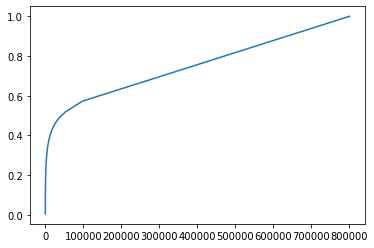

Top 10 patterns by freq account for 2.7225363823342073 % of the data.
Top 100 patterns by freq account for 8.639923078045152 % of the data.
Top 1000 patterns by freq account for 20.4608996270598 % of the data.
Top 10000 patterns by freq account for 38.12796905617442 % of the data.
Top 100000 patterns by freq account for 57.34636273904397 % of the data.
Top 500000 patterns by freq account for 81.65797931567663 % of the data.


In [6]:

values = sorted(list(counter_data.values()), reverse=True)
total = sum(values)
normalised = [x/total for x in values]
plt.plot(numpy.cumsum(normalised))
plt.show()


for k in [10, 100, 1000, 10000, 100000, 500000]:
    topk_patterns = {x[0] for x in counter_data.most_common(k)}
    topk_data = [x for x in data if x["dep"].lower() in topk_patterns]

    print(f"Top {k} patterns by freq account for {len(topk_data)/len(data) * 100} % of the data.")

#### Now double check that the dependency labels are going to roughly line up:

In [7]:
# Check all of the possible dependency labels:

spacy_deps = {'ROOT', 'acl', 'acl:relcl','advcl','advmod','amod','appos','aux','auxpass','case','cc','cc:preconj','ccomp',
              'compound','compound:prt','conj','cop','csubj','csubjpass','dep','det','det:predet','dobj','expl','iobj','list',
              'mark','mwe','neg','nmod','nmod:npmod','nmod:poss','nmod:tmod','nsubj','nsubjpass','nummod','parataxis','punct','xcomp'}

dependencies = set()
for path in distributions.keys():
    triples = path.split(" ")
    for triple in triples:
        head, rel, tail = triple.split("|")
        dependencies.add(rel)
        
print("In both")
print(dependencies.intersection(spacy_deps))

print("In dep paths but not spacy")
print(dependencies.difference(spacy_deps))

print("In spacy but not dep paths")
print(spacy_deps.difference(dependencies))

# Conclusion:
# Need to fix: 
# 'nsubj:xsubj', 'nsubjpass:xsubj' => 'nsubj', 'nsubjpass'


In both
{'dobj', 'nummod', 'nmod:poss', 'nsubjpass', 'iobj', 'det', 'list', 'dep', 'cop', 'nsubj', 'advcl', 'mark', 'nmod:npmod', 'advmod', 'nmod', 'case', 'csubjpass', 'acl', 'appos', 'compound:prt', 'aux', 'csubj', 'auxpass', 'cc', 'neg', 'parataxis', 'compound', 'nmod:tmod', 'amod', 'xcomp', 'ccomp', 'acl:relcl'}
In dep paths but not spacy
{'nsubj:xsubj', 'nsubjpass:xsubj', 'ref', 'discourse'}
In spacy but not dep paths
{'punct', 'mwe', 'conj', 'det:predet', 'expl', 'ROOT', 'cc:preconj'}



### Using Spacy's dependency matcher to "compile" patterns

Spacy has a very fully functional `Matcher` class, which allows matching for abitrary tokens/token sequences based off of a lot of different attributes. 
You can read about its features here: https://spacy.io/usage/rule-based-matching

It also has a lesser known `DependencyMatcher`, which allows you to match on dependency paths using semregex syntax:
https://nlp.stanford.edu/nlp/javadoc/javanlp/edu/stanford/nlp/semgraph/semgrex/SemgrexPattern.html

Overall, this combo allows us to do some interesting stuff with the dependency patterns. Below is an example for the following sentence:

##### "The ICE inhibitor Z-YVAD-FMK prevented the release of IL-1beta evoked by DNFB ."

with the following dependency path to match and extract:

##### "prevented|nsubj|START_ENTITY prevented|dobj|release release|nmod|END_ENTITY"

In [8]:
from spacy.matcher import DependencyMatcher
from collections import defaultdict
from typing import Dict, List

from scispacy.hack import clean_and_parse, parse_dep_path, check_for_non_trees


example = "prevented|nsubj|START_ENTITY prevented|dobj|release release|nmod|END_ENTITY"
sent = "The ICE inhibitor Z-YVAD-FMK prevented the release of IL-1beta evoked by DNFB ."

# rules are of the form: A | governs (via relation) | B
# So for semregex we need A > B OR B < A, which might be better as spacy t.dep_ refers to the word's parent.

#  For this subtree, it looks like:
#                prevented
#       start_ent           release
#                                   end_entity

def construct_pattern(rules: List[List[str]]):
    """
    Idea: add patterns to a matcher designed to find a subtree in a spacy dependency tree.
    Rules are strictly of the form "CHILD --rel--> PARENT". To build this up, we add rules
    in DFS order, so that the parent nodes have already been added to the dict for each child
    we encounter.
    """
    # Step 1: Build up a dictionary mapping parents to their children
    # in the dependency subtree. Whilst we do this, we check that there is
    # a single node which has only outgoing edges.

    if "dep" in {rule[1] for rule in rules}:
        return None

    ret = check_for_non_trees(rules)

    if ret is None:
        return None
    else:
        root, parent_to_children = ret

    def add_node(parent: str, pattern: List):
        
        for (rel, child) in parent_to_children[parent]:

            # First, we add the specification that we are looking for
            # an edge which connects the child to the parent.
            node = {
                "SPEC": {
                    "NODE_NAME": child,
                    "NBOR_RELOP": ">",
                    "NBOR_NAME": parent},
            }

            # DANGER we can only have these options IF we also match ORTH below, otherwise it's torturously slow.
            # token_pattern = {"DEP": {"IN": ["amod", "compound"]}}
            
            # Now, we specify what attributes we want this _token_
            # to have - in this case, we want to match a certain dependency
            # relation specifically.
            token_pattern = {"DEP": rel}

            # Additionally, we can specify more token attributes. So here,
            # if the node refers to the start or end entity, we require that
            # the word is part of an entity (spacy syntax is funny for this)
            # and that the word is a noun, as there are some verbs annotated as "entities" in medmentions.
            
            if child in {"START_ENTITY", "END_ENTITY"}:
                token_pattern["ENT_TYPE"] = {"NOT_IN": [""]}
                token_pattern["POS"] = "NOUN"
                
            # If we are on part of the path which is not the start/end entity,
            # we want the word to match. This could be made very flexible, e.g matching
            # verbs instead, etc.
            else:
                token_pattern["ORTH"] = child

            node["PATTERN"] = token_pattern

            pattern.append(node)
            add_node(child, pattern)

    pattern = [{"SPEC": {"NODE_NAME": root}, "PATTERN": {"ORTH": root}}]
    add_node(root, pattern)

    assert len(pattern) < 20
    return pattern

pattern = [
    {"SPEC": {"NODE_NAME": "prevented"}, "PATTERN": {"ORTH": "prevented"}},
    {"SPEC": {"NODE_NAME": "start_entity", "NBOR_RELOP": ">", "NBOR_NAME": "prevented"}, "PATTERN": {"DEP": "nsubj"}},
    {"SPEC": {"NODE_NAME": "release", "NBOR_RELOP": ">", "NBOR_NAME": "prevented"}, "PATTERN": {"DEP": "dobj", "ORTH":"release"}},
    {"SPEC": {"NODE_NAME": "end_entity", "NBOR_RELOP": ">", "NBOR_NAME": "release"}, "PATTERN": {"DEP": "nmod"}},

]


#### First take a look at the dependency path of the full sentence:

In [9]:
doc = nlp(sent)
visualise_doc(doc)
rules = [rule.split("|") for rule in example.split(" ")]
print(rules)
print()

[['prevented', 'nsubj', 'START_ENTITY'], ['prevented', 'dobj', 'release'], ['release', 'nmod', 'END_ENTITY']]



#### Now take a look at what happens if we apply this matcher pattern to the dependency tree:

In [10]:
constructed_pattern = construct_pattern(rules)
matcher = DependencyMatcher(nlp.vocab)

matcher.add("pattern1", None, constructed_pattern)

matches = matcher(doc)
print(matches)
subtree = matches[0][1][0]

visualise_subtrees(doc, subtree)

[(13439661873955722336, [[4, 3, 6, 8]])]
Subtree:  [4, 3, 6, 8]


found 48 matches (48.0 %)
Found 25 patterns of length 2
Found 18 patterns of length 3
Found 5 patterns of length 4
Found 41 unique patterns

Top found patterns by freq:
synthesized|nmod|start_entity synthesized|nsubjpass|end_entity 			 3
inhibitor|appos|start_entity inhibitor|compound|end_entity 			 2
inhibitor|appos|start_entity inhibitor|amod|end_entity 			 2
inhibitor|nsubj|start_entity inhibitor|nmod|end_entity 			 2
inhibitor|nsubj|start_entity inhibitor|compound|end_entity 			 2
reduced|nsubj|start_entity reduced|dobj|expression expression|compound|end_entity 			 2
blocked|nsubj|start_entity blocked|nmod|end_entity 			 1
induce|nmod|start_entity induce|dobj|production production|nmod|end_entity 			 1
realgar|appos|start_entity realgar|appos|end_entity 			 1
cleaved|nmod|start_entity cleaved|nsubjpass|end_entity 			 1
affect|nsubj|start_entity affect|dobj|expression expression|nmod|end_entity 			 1
inhibitor|appos|start_entity inhibitor|appos|end_entity 			 1
that|nmod|start_entit

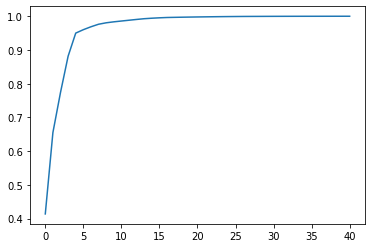

In [11]:

from spacy.tokens import Doc
from scispacy.util import WhitespaceTokenizer

nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

found = 0
pattern_lengths = defaultdict(int)
good_patterns = Counter()
examples = 100
for d in data[-examples:]:
    subtree = parse_dep_path(d["dep"])
    
    pattern = construct_pattern(subtree)
    
    if pattern is None:
        continue
        
    doc = clean_and_parse(d["sent"], nlp)
    
    matcher = DependencyMatcher(nlp.vocab)
    matcher.add("pattern1", None, pattern)

    matches = matcher(doc)
               
    match = matches[0]
    if match[1]:
        found +=1
        pattern_lengths[len(subtree)] +=1
        good_patterns[d["dep"].lower()] +=1

print(f"found {found} matches ({found/examples  * 100} %)")
for k,v in pattern_lengths.items():
    print(f"Found {v} patterns of length {k}")
    
print(f"Found {len(good_patterns)} unique patterns")

print()
print("Top found patterns by freq:")
for k,v in good_patterns.most_common(50):
    print(k, "\t\t\t", v)

values = sorted([counter[p] for p in good_patterns.keys()], reverse=True)
total = sum(values)
normalised = [x/total for x in values]
plt.plot(numpy.cumsum(normalised))
plt.show()


In [12]:
len({d["dep"].lower() for d in data[-examples:]})
bad_pattern_data = [d for d in data[-examples:] if d["dep"].lower() not in good_patterns]

In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import random
random.shuffle(bad_pattern_data)
for d in bad_pattern_data[:1000]:
    
    if len(d["sent"].split(" ")) > 15:
        continue
    visualise_doc(clean_and_parse(d["sent"], nlp))
    print(d["dep"])
    print("Entity 1: ", d["ent1"] )
    print("Entity 2: ", d["ent2"] )    
    print()
    
# OBSERVATIONS:
# Check why this wasn't picked up
# A recent study T062 using mice T015 carrying a mutation T045 in a specific tyrosine T116 residue of trkB T116 pinpoints a necessary role for the phospholipase-Cgamma -LRB- T116 PLCgamma -RRB- pathway T044 in CREB activation T044 and LTP T042 maintenance T052 .
# residue|compound|START_ENTITY residue|nmod|END_ENTITY
# Entity 1:  tyrosine
# Entity 2:  trkB
#


# acl vs appos
# amods are often annotated as compound nouns - for amod, maybe allow compound IMPORTANT this will fix many examples
# dep => allow any edge, as the parse was wrong

# What happens if we throw away all relations and just use unlabeled edges?
# Some parsing errors come from weird attachments to brackets, what happens if we merge those tokens before using the abbreviation detector
# !!!! What is going wrong with punctuation parsing, should _always_ attach to root 
# ANSWER: dumb, this is because the sentences have line breaks at the end. dumb. This will fix many examples



START_ENTITY|appos|peptide peptide|compound|END_ENTITY
Entity 1:  Zyklophin
Entity 2:  kappa_opioid_receptor



antagonist|nsubj|START_ENTITY antagonist|compound|END_ENTITY
Entity 1:  ZXH951
Entity 2:  progesterone_receptor



reduced|nsubj|START_ENTITY reduced|dobj|expression expression|compound|END_ENTITY
Entity 1:  Zyflamend
Entity 2:  androgen_receptor



detected|nmod|START_ENTITY detected|nsubjpass|END_ENTITY
Entity 1:  ZY106
Entity 2:  qnrS1



In [12]:

from scispacy.relation_extraction import RelationExtractor
import random


relex = RelationExtractor(nlp.vocab, "freq_dep_paths.jsonl", 20)


for d in random.sample(data, 100):

    doc = clean_and_parse(d["sent"], nlp)
    
    relex(doc)
    
    has_match = any( x[1] != [] for x in relex.matches)
    if not has_match:
        continue
        
    visualise_doc(doc)
    for match, subtrees in relex.matches:
        unique = [t for t in subtrees if len(set(t)) == len(t)]
        
        if not unique:
            continue
        print(f"Matches for pattern: {relex.matcher.vocab.strings[match]}")
        visualise_subtrees(doc, unique)
        
        
        

Loaded 742 patterns


Matches for pattern: role|nmod|start_entity role|nmod|end_entity
Subtree:  [32, 34, 37]


Subtree:  [32, 37, 34]


Matches for pattern: effect|nmod|start_entity effect|nmod|end_entity
Subtree:  [2, 4, 7]


Subtree:  [2, 7, 4]


Matches for pattern: role|nmod|start_entity role|nmod|end_entity
Subtree:  [16, 18, 22]


Subtree:  [16, 22, 18]


Matches for pattern: associated|nsubjpass|start_entity associated|nmod|end_entity
Subtree:  [28, 22, 32]


Matches for pattern: associated|nmod|start_entity associated|nsubjpass|end_entity
Subtree:  [28, 32, 22]


Matches for pattern: antagonist|compound|start_entity antagonist|compound|end_entity
Subtree:  [10, 5, 7]


Subtree:  [10, 7, 5]


Matches for pattern: antagonist|compound|start_entity antagonist|compound|end_entity
Subtree:  [23, 20, 22]


Subtree:  [23, 22, 20]


Matches for pattern: response|nmod|start_entity response|compound|end_entity
Subtree:  [1, 3, 0]


Matches for pattern: response|compound|start_entity response|nmod|end_entity
Subtree:  [1, 0, 3]


Matches for pattern: effect|nmod|start_entity effect|nmod|end_entity
Subtree:  [1, 3, 6]


Subtree:  [1, 6, 3]


Matches for pattern: activation|nmod|start_entity activation|compound|end_entity
Subtree:  [19, 21, 18]


Matches for pattern: activation|compound|start_entity activation|nmod|end_entity
Subtree:  [19, 18, 21]


Matches for pattern: induce|nsubj|start_entity induce|dobj|end_entity
Subtree:  [39, 36, 40]


Matches for pattern: levels|compound|start_entity levels|compound|end_entity
Subtree:  [14, 12, 13]


Subtree:  [14, 13, 12]


Matches for pattern: expression|nmod|start_entity expression|nmod|end_entity
Subtree:  [19, 21, 24]


Subtree:  [19, 24, 21]


Matches for pattern: activity|compound|start_entity activity|compound|end_entity
Subtree:  [3, 1, 2]


Subtree:  [3, 2, 1]


Matches for pattern: inactivation|nmod|start_entity inactivation|nmod|end_entity
Subtree:  [0, 2, 4]


Subtree:  [0, 4, 2]


Matches for pattern: inhibited|nmod|start_entity inhibited|nsubjpass|end_entity
Subtree:  [5, 9, 2]


Matches for pattern: inhibitors|appos|start_entity inhibitors|compound|end_entity
Subtree:  [9, 10, 8]


Matches for pattern: inhibited|nmod|start_entity inhibited|nsubjpass|activity activity|compound|end_entity
Subtree:  [5, 9, 2, 1]


Matches for pattern: expression|nmod|start_entity expression|nmod|end_entity
Subtree:  [23, 25, 30]


Subtree:  [23, 30, 25]


Matches for pattern: inhibition|nmod|start_entity inhibition|compound|end_entity
Subtree:  [1, 3, 0]


Matches for pattern: inhibition|compound|start_entity inhibition|nmod|end_entity
Subtree:  [1, 0, 3]


Matches for pattern: inhibits|nsubj|start_entity inhibits|dobj|end_entity
Subtree:  [6, 5, 7]


Subtree:  [27, 25, 28]


Matches for pattern: inhibits|nsubj|start_entity inhibits|nmod|end_entity
Subtree:  [6, 5, 9]


Subtree:  [27, 25, 31]


Matches for pattern: regulated|nmod|start_entity regulated|nsubjpass|end_entity
Subtree:  [33, 35, 4]


Matches for pattern: inhibited|nsubj|start_entity inhibited|dobj|end_entity
Subtree:  [3, 0, 4]


Matches for pattern: inhibited|nsubj|start_entity inhibited|dobj|phosphorylation phosphorylation|nmod|end_entity
Subtree:  [3, 0, 4, 6]


Matches for pattern: induce|nsubj|start_entity induce|dobj|end_entity
Subtree:  [6, 3, 9]


Matches for pattern: increased|nsubj|start_entity increased|nmod|end_entity
Subtree:  [19, 18, 24]


Subtree:  [19, 18, 27]


Matches for pattern: increased|nmod|start_entity increased|nsubj|end_entity
Subtree:  [19, 24, 18]


Subtree:  [19, 27, 18]


Matches for pattern: decreased|nsubj|start_entity decreased|nmod|end_entity
Subtree:  [36, 35, 41]


Matches for pattern: release|nmod|start_entity release|compound|end_entity
Subtree:  [14, 19, 7]


Matches for pattern: regulates|nsubj|start_entity regulates|dobj|end_entity
Subtree:  [6, 5, 7]


Matches for pattern: activity|compound|start_entity activity|compound|end_entity
Subtree:  [44, 42, 43]


Subtree:  [44, 43, 42]


Matches for pattern: inhibited|nsubj|start_entity inhibited|dobj|end_entity
Subtree:  [22, 19, 25]


Matches for pattern: activity|compound|start_entity activity|compound|end_entity
Subtree:  [16, 14, 15]


Subtree:  [16, 15, 14]


Subtree:  [29, 27, 28]


Subtree:  [29, 28, 27]


Matches for pattern: increased|nsubj|start_entity increased|dobj|end_entity
Subtree:  [10, 9, 12]


Matches for pattern: increased|dobj|start_entity increased|nsubj|end_entity
Subtree:  [10, 12, 9]


Matches for pattern: activate|nsubj|start_entity activate|dobj|end_entity
Subtree:  [15, 8, 16]


Matches for pattern: inhibits|nsubj|start_entity inhibits|dobj|end_entity
Subtree:  [1, 0, 5]


Matches for pattern: inhibits|nsubj|start_entity inhibits|dobj|end_entity
Subtree:  [1, 0, 3]


Matches for pattern: increases|nsubj|start_entity increases|dobj|expression expression|nmod|end_entity
Subtree:  [5, 4, 7, 9]


Subtree:  [5, 4, 7, 11]


Matches for pattern: expression|nmod|start_entity expression|nmod|end_entity
Subtree:  [7, 9, 11]


Subtree:  [7, 11, 9]


Matches for pattern: inhibitors|nmod|start_entity inhibitors|compound|end_entity
Subtree:  [7, 9, 6]


Matches for pattern: inhibited|nsubj|start_entity inhibited|dobj|end_entity
Subtree:  [20, 5, 22]


Matches for pattern: involved|nmod|start_entity involved|nsubjpass|end_entity
Subtree:  [40, 43, 37]


Matches for pattern: inhibitor|compound|start_entity inhibitor|compound|end_entity
Subtree:  [8, 1, 4]


Subtree:  [8, 4, 1]


Matches for pattern: inhibitor|nsubj|start_entity inhibitor|nmod|end_entity
Subtree:  [12, 5, 15]


Matches for pattern: inhibitor|nsubj|start_entity inhibitor|compound|end_entity
Subtree:  [12, 5, 9]


Subtree:  [12, 5, 10]


Subtree:  [12, 5, 11]


Matches for pattern: inhibitor|nsubj:xsubj|start_entity inhibitor|nmod|end_entity
Subtree:  [12, 5, 15]


Matches for pattern: inhibitor|nmod|start_entity inhibitor|compound|end_entity
Subtree:  [12, 15, 9]


Subtree:  [12, 15, 10]


Subtree:  [12, 15, 11]


Matches for pattern: inhibitor|compound|start_entity inhibitor|compound|end_entity
Subtree:  [12, 9, 10]


Subtree:  [12, 9, 11]


Subtree:  [12, 10, 9]


Subtree:  [12, 10, 11]


Subtree:  [12, 11, 9]


Subtree:  [12, 11, 10]


Matches for pattern: expression|nmod|start_entity expression|compound|end_entity
Subtree:  [13, 18, 12]


Matches for pattern: induced|nsubj|start_entity induced|dobj|expression expression|nmod|end_entity
Subtree:  [10, 1, 13, 18]


Matches for pattern: induced|nsubj|start_entity induced|dobj|expression expression|compound|end_entity
Subtree:  [10, 1, 13, 12]


Matches for pattern: induced|nsubj|start_entity induced|dobj|end_entity
Subtree:  [10, 1, 13]


Matches for pattern: had|nsubj|start_entity had|nmod|end_entity
Subtree:  [7, 6, 13]


Subtree:  [7, 6, 26]


Matches for pattern: had|nmod|start_entity had|nsubj|end_entity
Subtree:  [7, 13, 6]


Subtree:  [7, 26, 6]


Matches for pattern: antagonists|compound|start_entity antagonists|compound|end_entity
Subtree:  [10, 8, 9]


Subtree:  [10, 9, 8]


Matches for pattern: inhibitor|nsubj|start_entity inhibitor|nmod|end_entity
Subtree:  [8, 4, 10]


Matches for pattern: inhibitor|nsubj:xsubj|start_entity inhibitor|nmod|end_entity
Subtree:  [8, 4, 10]


Matches for pattern: response|nmod|start_entity response|compound|end_entity
Subtree:  [8, 10, 7]


Matches for pattern: reduced|nsubj|start_entity reduced|dobj|end_entity
Subtree:  [5, 4, 8]


Matches for pattern: response|compound|start_entity response|nmod|end_entity
Subtree:  [8, 7, 10]


Matches for pattern: inhibited|nsubj|start_entity inhibited|dobj|end_entity
Subtree:  [4, 2, 7]


Matches for pattern: inhibited|nsubj|start_entity inhibited|dobj|phosphorylation phosphorylation|compound|end_entity
Subtree:  [4, 2, 7, 6]


Matches for pattern: encodes|dobj|start_entity encodes|nsubj|end_entity
Subtree:  [3, 6, 2]


Matches for pattern: reduced|nsubj|start_entity reduced|dobj|end_entity
Subtree:  [2, 0, 6]


Matches for pattern: activity|compound|start_entity activity|compound|end_entity
Subtree:  [6, 4, 5]


Subtree:  [6, 5, 4]


Matches for pattern: decreased|nsubj|start_entity decreased|dobj|end_entity
Subtree:  [5, 4, 11]


Matches for pattern: expression|nmod|start_entity expression|compound|end_entity
Subtree:  [27, 30, 24]


Matches for pattern: sequence|amod|start_entity sequence|nmod|end_entity
Subtree:  [3, 2, 6]


Matches for pattern: contains|dobj|start_entity contains|nsubj|end_entity
Subtree:  [7, 10, 3]
